In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import struct
import array
import os
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator, LinearNDInterpolator

# Athena++ modules
# import athena_read
import athena_read_select
import h5py
import netCDF4
import xarray as xr

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
filename = 'disk.out1.00100.athdf'

In [3]:
q = 0.9e-3
Rh = (q/3) ** (1/3)

In [4]:
leveln = None
quantities=['rho','press','vel1','vel2','vel3']
with h5py.File(filename, 'r') as f:
      attributes = f.attrs.items()
      attrs = dict(attributes)
      level = f.attrs['MaxLevel']
      time = f.attrs['Time']

subsample = False
if leveln is not None:
    if level > leveln:
        subsample = True
    level = leveln
data = athena_read_select.athdf(filename, quantities=quantities,
    level=level, subsample=subsample)

b'spherical_polar'
[b'prim']
4
[24 24 24]
1480314
2772
[5]
[168  72 576]
[0.4      2.5      1.003814]
[1.3962634 1.7453293 1.       ]
[0.        6.2831855 1.       ]
628.31854
[b'rho' b'press' b'vel1' b'vel2' b'vel3']


In [5]:
data['rho'].shape

(294, 662, 280)

In [6]:
thetapos=np.abs(data['x2v']-0.5*np.pi).argmin()
phipos=400

In [7]:
r = data['x1v']
theta = data['x2v']
phi = data['x3v']

In [8]:
rp, thetap, phip = 1, np.pi / 2, np.pi

In [9]:
rho = data['rho']

In [10]:
# making r, theta, and phi 3D arrays
r = r[np.newaxis, np.newaxis, :]
theta = theta[np.newaxis, :, np.newaxis]
phi = phi[:, np.newaxis, np.newaxis]

In [11]:
vr = data['vel1']
vtheta = data['vel2']
vphi = data['vel3']

In [12]:
theta.shape

(1, 662, 1)

In [13]:
# recentering the coordinates to make the planet-centered
r_new = np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi))
phi_new = np.arctan2(r * np.sin(theta) * np.sin(phi), r * np.sin(theta) * np.cos(phi) + rp)
theta_new = np.arccos(r * np.cos(theta) / np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)))

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_19234/1201654965.py:4: RuntimeWarning: invalid value encountered in arccos
  theta_new = np.arccos(r * np.cos(theta) / np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)))


In [14]:
from itertools import product

In [15]:
def searchsorted(l, x):
    for i in l:
        if i >= x: break
    # return l.index(i)
    return np.where(l == i)[0][0]

def trilinear_interpolation(x_volume, y_volume, z_volume, volume, x_needed, y_needed, z_needed):
    """
    Trilinear interpolation (from Wikipedia)

    :param x_volume: x points of the volume grid 
    :type crack_type: list or numpy.ndarray
    :param y_volume: y points of the volume grid 
    :type crack_type: list or numpy.ndarray
    :param x_volume: z points of the volume grid 
    :type crack_type: list or numpy.ndarray
    :param volume:   volume
    :type crack_type: list or numpy.ndarray
    :param x_needed: desired x coordinate of volume
    :type crack_type: float
    :param y_needed: desired y coordinate of volume
    :type crack_type: float
    :param z_needed: desired z coordinate of volume
    :type crack_type: float

    :return volume_needed: desired value of the volume, i.e. volume(x_needed, y_needed, z_needed)
    :type volume_needed: float
    """
    # dimensinoal check
    if np.shape(volume) != (len(x_volume), len(y_volume), len(z_volume)):
        raise ValueError(f'dimension mismatch, volume must be a ({len(x_volume)}, {len(y_volume)}, {len(z_volume)}) list or numpy.ndarray')
    # check of the indices needed for the correct control volume definition
    i = searchsorted(x_volume, x_needed)
    j = searchsorted(y_volume, y_needed)
    k = searchsorted(z_volume, z_needed)
    # control volume definition
    control_volume_coordinates = np.array(
        [[x_volume[i - 1], y_volume[j - 1], z_volume[k - 1]], [x_volume[i], y_volume[j], z_volume[k]]])
    xd = (np.array([x_needed, y_needed, z_needed]) - control_volume_coordinates[0]) / (control_volume_coordinates[1] - control_volume_coordinates[0])
    # interpolation along x
    c2 = [[0, 0], [0, 0]]
    for m, n in product([0, 1], [0, 1]):
        c2[m][n] = volume[i - 1][j - 1 + m][k - 1 + n] * (1 - xd[0]) + volume[i][j - 1 + m][k - 1 + n] * xd[0]
    # interpolation along y
    c1 = [0, 0]
    c1[0] = c2[0][0] * (1 - xd[1]) + c2[1][0] * xd[1]
    c1[1] = c2[0][1] * (1 - xd[1]) + c2[1][1] * xd[1]
    # interpolation along z
    volume_needed = c1[0] * (1 - xd[2]) + c1[1] * xd[2]
    return volume_needed

In [16]:
trilinear_interpolation(data['x3v'], data['x2v'], data['x1v'], vr, 2.942857, np.pi/2, 0.950568)

0.17461335351370422

In [17]:
np.where(np.isclose(data['x3v'],2.942857))

(array([], dtype=int64),)

In [18]:
np.where(np.isclose(data['x2v'],np.pi/2))

(array([331]),)

In [19]:
np.where(np.isclose(data['x1v'],0.950568))

(array([], dtype=int64),)

In [20]:
nanmask = np.isnan(theta_new)

In [21]:
from scipy.interpolate import griddata

In [22]:
N=100
phi_points = np.linspace(0,2*np.pi, N)
theta_points = np.linspace(0,np.pi,N)
r_points = np.ones(N) * Rh

grid_phi, grid_theta, grid_r = np.meshgrid(phi_points,theta_points,r_points, indexing="ij")

In [23]:
griddata(np.stack((phi_new[~nanmask],theta_new[~nanmask],r_new[~nanmask])).reshape(3,-1).T, rho[~nanmask].flatten(), (2.942857, np.pi/2, 0.950568), method='linear')

: 

: 

In [32]:
rho.shape

(588, 1152, 560)

In [26]:
N=10_000
interp_den = np.zeros((N,N))
phi_points = np.linspace(0,2*np.pi, N)
theta_points = np.linspace(0,np.pi,N)
r_points = np.ones(N) * Rh
for i in range(N):
     for j in range(N):
          interp_den[i][j] = trilinear_interpolation(phi_new, theta_new, r_new, rho, phi_points[i], theta_points[j], Rh)

ValueError: dimension mismatch, volume must be a (588, 588, 588) list or numpy.ndarray

In [ ]:
phi_new[:,0,0].shape

(588,)

In [ ]:
lon = np.pi - phi_new % (2*np.pi)
lat = np.pi/2 - theta_new % np.pi

ValueError: 'c' argument has 10000 elements, which is inconsistent with 'x' and 'y' with size 379330560.

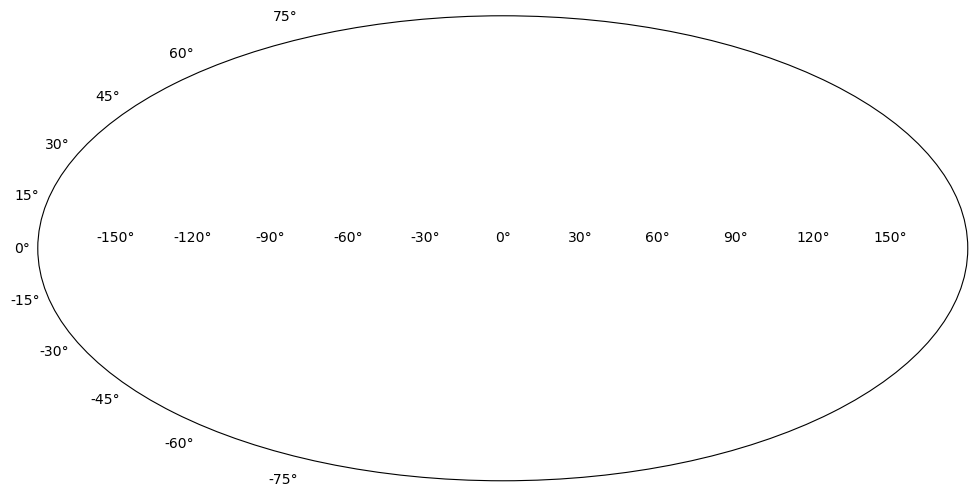

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='mollweide')
cax = ax.scatter(lon, lat, c=interp_den, s=10, cmap='plasma')
# ax.grid(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
cbar.set_label('Density')
plt.show()